# Examples of utils provided by ReGraph's Neo4jHierarchy module

In [1]:
import networkx as nx
from regraph import Rule, plot_rule

from regraph.neo4j.hierarchy import Neo4jHierarchy
import regraph.neo4j.cypher_utils as cypher
import regraph.neo4j.result_utils as rs

## Initializing Neo4j database

0. When installing neo4j you will be asked to choose login/password for you dbs (here its "neo4j"/"admin"), if you choose other -- change in the cell below.
1. To start neo4j server run `sudo service neo4j start`
2. Check status by running `sudo service neo4j status`. Here you can check the _bolt_ port, change the cell below if different from 7687
3. You can query the db by using the neo4j browser, the address can be found also in the result of 'status', e.g. "Remote interface available at http://localhost:7474/".

In [2]:
# initialize the neo4j driver, wrappped into Neo4jHierarchy object
h = Neo4jHierarchy(uri="bolt://localhost:7687", user="neo4j", password="admin")

In [3]:
#here we clear the hierarchy
h.clear()
#

## Hierarchy

A hierarchy is represented by at least 2 graphs with a typing relation (homorphism) between them.


Each graph in the database is represented by a unique label which enables us to match quickly the nodes of this graph. Each node of a graph has then the labels *node* and *graphLabel*. We can match these nodes by using the query:

> MATCH (n:node:graphLabel) RETURN n


The edges of a graph are labeled as *edge* and the typing edges are labeled as *typing*. We can then easily find the image of a node with the query:

> OPTIONAL MATCH (n:node:graphLabel)-[:typing]->(m) RETURN m

The hierarchy skeleton is represented by nodes labeled as hierarchyNodes. It enables us to know which graphs are the ancestors of a graph we want to rewrite for example.

## Adding a graph to the hierarchy (Action Graph)

Here we create a first graph called *ActionGraph*. This graph represent people and the relationship between them.

In [4]:
h.add_graph('actionGraph')

In [5]:
ag = h.access_graph('actionGraph')

In [6]:
nodes = [
    ("a", {"name": "Jack", "age": 23, "hobby": {"hiking", "music"}, "weight": 75}), 
    ("b", {"name": "Bob", "age": 24, "hobby": {"sport", "music"}, "height": 178}),
    "c", 
    ("d", {"name": "Paul"}), "e", "f"
]
edges = [
    ("a", "b", {"type": {"friends", "colleagues"}}), 
    ("d", "b", {"type": "enemies"}), 
    ("a", "c"),
    ("d", "a", {"type": "friends"}),
    ("e", "a"), 
    ("f", "d")
]
ag.add_nodes_from(nodes)
ag.add_edges_from(edges)

## Adding a second graph to the herarchy (Meta Model)

Here we create a second graph called *MetaModel*. Which represent the types of people (*Adult* or *Child*) and the relationships between them.

In [7]:
h.add_graph('metaModel')

In [8]:
mm = h.access_graph('metaModel')

In [9]:
nodes = [
    ("a", {"type": "Adult"}),
    ("b", {"type": "Child"})
]
edges = [
    ("a", "a", {"type": {"friends", "colleagues", "enemies"}}),
    ("a", "b", {"type": {"friends", "colleagues", "enemies"}}),
    ("b", "a", {"type": {"friends", "colleagues", "enemies"}}),
    ("b", "b", {"type": {"friends", "colleagues", "enemies"}})
]
mm.add_nodes_from(nodes)
mm.add_edges_from(edges)

## Typing

Here we create a typing of the *ActionGraph* on the *MetaModel*.

In [10]:
mapping = {
    "a":"a",
    "b":"a",
    "c":"b",
    "d":"b",
    "e":"b",
    "f":"b"
}
h.add_typing('actionGraph', 'metaModel', mapping)

## Classic update functions

We still can use the modification functions on these grapphs.

In [11]:
#ag.merge_nodes(["b", "c"])

In [12]:
#mm.clone_node("a")

## Graph rewriting

In [13]:
pattern = nx.DiGraph()
pattern.add_nodes_from(["x", "y"])
pattern.add_edges_from([("y", "x"), ("y", "y")])

In [14]:
rule = Rule.from_transform(pattern)
clone_name1, _ = rule.inject_clone_node("y")
#rule.inject_remove_edge(clone_name2, clone_name1)
rule.inject_remove_node("x")
rule.inject_add_node("new_node")
rule.inject_add_edge("new_node", clone_name1)

In [15]:
print(rule.cloned_nodes())
print(rule.added_nodes())
print(rule.removed_nodes())
print(rule.added_edges())
print(rule.removed_edges())
print(rule.merged_nodes())

{'y': {'y1', 'y'}}
{'new_node'}
{'x'}
{('new_node', 'y1')}
set()
{}


/home/florian/Documents/Code/env3/lib/python3.6/site-packages/matplotlib-2.2.2-py3.6-linux-x86_64.egg/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/florian/Documents/Code/env3/lib/python3.6/site-packages/networkx-1.11-py3.6.egg/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecation

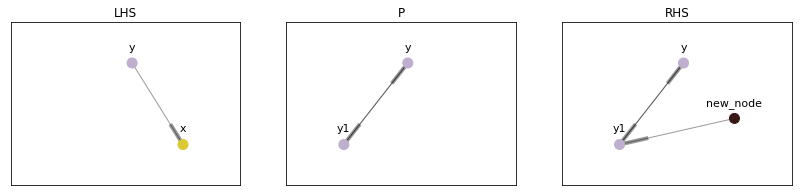

In [16]:
plot_rule(rule)

In [17]:
instances = mm.find_matching(pattern)
print("Instances: ", instances)

Instances:  [{'x': 'b', 'y': 'a'}, {'x': 'a', 'y': 'b'}]


In [18]:
h.rewrite('metaModel', rule, instances[0])

y {'y1', 'y'}
-------------
y1
y
Rewriting rule to Cypher: 

// Match nodes and edges of the instance 
MATCH (lhs_x:node:metaModel { id : 'b'}), (lhs_y:node:metaModel { id : 'a'}) , (lhs_y)-[lhs_y_lhs_x:edge]->(lhs_x), (lhs_y)-[lhs_y_lhs_y:edge]->(lhs_y)

// Cloning node 'y' of the lhs 
// Create clone corresponding to 'y1' of the preserved part
// create a node corresponding to the clone
CREATE (p_y1:node:metaModel) 
WITH p_y1, toString(id(p_y1)) as p_y1_id, lhs_y.id as original_old, lhs_y, lhs_x 
// set the id property of the original node to NULL
SET lhs_y.id = NULL
// copy all the properties of the original node to the clone
SET p_y1 = lhs_y
// set id property of the clone to neo4j-generated id
SET p_y1.id = toString(id(p_y1)), p_y1.count = NULL
// set back the id property of the original node
SET lhs_y.id = original_old
WITH p_y1, toString(id(p_y1)) as p_y1_id, lhs_y, lhs_x 
WITH [] as sucIgnore, [] as predIgnore, lhs_y, lhs_x, p_y1 
// Match successors and out-edges of a node to 

{}

In [19]:
h.propagation_up('metaModel')

Rewritting ancestors of metaModel...
actionGraph
Rewritting ancestors of actionGraph...


## Removing a graph from the hierarchy

We can also remove a graph from the hierarchy. All its nodes and connections (edges and typing edges) are removed.

In [20]:
#h.remove_graph('MetaModel')